# Study 2023 Canadian Wildfires using Direct-S3(EarthdataCloud) TROPESS CrIS JPSS-1 Carbon Monoxide (CO) data products

**Summary:**

This code reads **TROPESS CrIS JPSS-1 Carbon Monoxide (CO)** data products for June 2023 and June 2022 directly from S3 on **NASA Earthdata Cloud** and makes a monthly average data product and plots and compares each monthly average.

A .netrc file containing an individual user's **NASA Earthdata Login** credentials (not supplied with this notebook) must be provided by each user intending to operate this notebook from their own AWS cloud environment. Below are the steps to creating a .netrc file:

  1. Create an **Earthdata Login Account** ([clear here for details](https://urs.earthdata.nasa.gov/users/new))
  2. Approve access to the **NASA GES DISC Archive** in your Earthdata Login Profile ([click here for details](https://disc.gsfc.nasa.gov/earthdata-login))
  3. Create/modify a **.netrc** file in your home directory containing your **Earthdata Login** credentials as shown below:
     <br>`machine urs.earthdata.nasa.gov login <your username> password <your password>`


**Other important notes:**

  1. This code was designed and tested **"as-is"** to run directly with an **AWS cloud-based Jupyter Hub** environment for direct cloud-based S3 access; as such, this is **NOT** intended to run in a local (i.e., on-premise) Jupyter environment.  
  2. Please "trust" this notebook before executing; this will prevent errors when writing output to your local directory.

In [1]:
import datetime
import contextlib

import requests

from pathlib import Path

import os
import s3fs
import xarray as xr

import pandas as pd

import numpy as np
from netCDF4 import Dataset
import h5netcdf

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from scipy.interpolate import griddata
from scipy.spatial import cKDTree


# Create a Function for CMR Catalog Requests

In [2]:
def cmr_request(params):
    response = requests.get(url,
                        params=params,
                        headers={
                            'Accept': 'application/json',
                        }
                       )
    return response

# Search CMR Catalogs and Obtain S3 URLs
## Check that the CMR catalog can be accessed

If "200, CMR is accessible" is returned, the catalog can be accessed!


In [3]:
url = 'https://cmr.earthdata.nasa.gov/search/collections'

# Create our request for finding cloud-hosted granules, and check that we can access CMR
response = cmr_request({
                        'cloud_hosted': 'True',
                        'has_granules': 'True'
                        })

if response.status_code == 200:
    print(str(response.status_code) + ", CMR is accessible")
else:
    print(str(response.status_code) + ", CMR is not accessible, check for outages")

200, CMR is accessible


# Search CMR with your desired data collection's shortname or concept ID and desired date range

Using the collection's shortname or concept ID, we can obtain individual granules by querying https://cmr.earthdata.nasa.gov/search/granules. By querying a JSON response of the granules that we want, we can obtain each granule's S3 URL.

Here, we will parse out an S3 URL for the "TROPESS CrIS-JPSS1 L2 Carbon Monoxide for Forward Stream, Summary Product V1" dataset.

   **Shortname**: TRPSYL2COCRS1FS  
   **Concept ID**: C2247040116-GES_DISC

Our desried date range is June 1, 2023 00:00:00 to June 30, 2023 23:59:59.


In [4]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

short_name = 'TRPSYL2COCRS1FS'
concept_id = 'C2247040116-GES_DISC'

start_time = '2023-06-01T00:00:00Z'
end_time = '2023-06-30T23:59:59Z'

# OPTION 1: Using shortname
response = cmr_request({
                        'short_name': short_name,
                        'temporal': start_time+','+end_time,
                        'page_size': 200
                        })

# OPTION 2: Using concept ID
response = cmr_request({
                        'concept_id': concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': 200
                        })

granules = response.json()['feed']['entry']

# Identify the S3 URL from each granule response and save to a list

Now you can create an empty list and fill it with the S3 URL contained in each granule's response.

In [5]:
s3_urls = []
for granule in granules:
    s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

# View your list of S3 URLs

In [6]:
s3_urls

['s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230601_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230602_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230603_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230604_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230605_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230606_MUSES_R1p20_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230607_MUSES_R1p20_FS_F0

### Get S3 Token

Retrieve your S3 access token and define an S3 direct access file system handler with S3FS. This token expires after one hour, and this block will need to be rerun if time expires. If you receive an error, double-check that your username and password were entered correctly in your netrc file, or that you can access the following URL: https://data.gesdisc.earthdata.nasa.gov

In [7]:
gesdisc_s3 = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

# Define a function for S3 access credentials

def begin_s3_direct_access(url: str=gesdisc_s3):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(fs)

s3fs.core.S3FileSystem

# Open the File in Xarray as an S3 File System Object

### First, check that the file itself is intact. By calling fs.info() with S3FS, we can see some of the metadata assigned to files uploaded to S3 buckets.

In [8]:
# Files are organized by s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/year/*.nc
fn = 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230601_MUSES_R1p20_FS_F0p6.nc'

fs.info(fn)

{'ETag': '"ecdcd691ff8dcc5956994c2e67ad6fc2"',
 'LastModified': datetime.datetime(2023, 10, 13, 18, 57, 32, tzinfo=tzutc()),
 'size': 12551452,
 'name': 'gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230601_MUSES_R1p20_FS_F0p6.nc',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'binary/octet-stream'}

### Now try reading the previous sample data file.

In [9]:
dataset = xr.open_dataset(fs.open(f"{fn}"), decode_cf=True, engine='h5netcdf')

# Now we will pass in the first month of data from June 2023 directly from S3.

## Let's read the June 2023 daily data products and make a time series and make a monthly average of XCO (column CO).

In [10]:
# Define the time series array for the 'x' column
x_col_time_series_2023_june = []

# Loop over all files in the file list
for nc_file in s3_urls:
    fn = nc_file
    print("reading data from =", fn)
    fs.info(fn)
    dataset = xr.open_dataset(fs.open(f"{fn}"), decode_cf=True, engine='h5netcdf')
    
    # Read the data from your variables
    latitude = dataset.variables['latitude'][:]
    longitude = dataset.variables['longitude'][:]
    x_col = dataset.variables['x_col'][:]    

    dataset.close()

    # Filter the data for latitude 60S to 80N
    latitude_max = 80.0
    latitude_min = -60.0
    longitude_max = 180.0
    longitude_min = -180.0

    selection_only = np.where(
        (latitude > latitude_min) & (latitude < latitude_max) & 
        (longitude > longitude_min) &(longitude < longitude_max)
    )[0]

    latitude = latitude[selection_only]
    longitude = longitude[selection_only]
    x_col = x_col[selection_only]

    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    # Interpolate the data using griddata
    grid_x_col = griddata((latitude, longitude), x_col, (grid_lat, grid_lon), method='linear', rescale=True)

    # Find the distance to the nearest original point for each point in the interpolated grid
    tree = cKDTree(np.vstack((latitude, longitude)).T)
    dist, _ = tree.query(np.vstack((grid_lat.ravel(), grid_lon.ravel())).T)

    # Reshape the distance array to have the same shape as the x_col grid
    dist_grid = dist.reshape(grid_x_col.shape)

    # Mask the interpolated values that are too far from any original point
    max_distance_degrees = 3.0
    grid_x_col[dist_grid > max_distance_degrees] = np.nan
    
    # Make the time series of daily x_col for one month by appending each day's dataset. 
    x_col_time_series_2023_june.append(grid_x_col)

x_col_time_series_2023_june = np.array(x_col_time_series_2023_june)    
print(x_col_time_series_2023_june.shape)
x_col_month_mean_2023 = np.mean(x_col_time_series_2023_june, axis=0)

reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230601_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230602_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230603_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230604_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230605_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2023/TROPESS_CrIS-JPSS1_L2_Summary_CO_20230606_MUSES_R1p20_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus

### Next let's make a global map of the June 2023 averaged XCO using Basemap. 

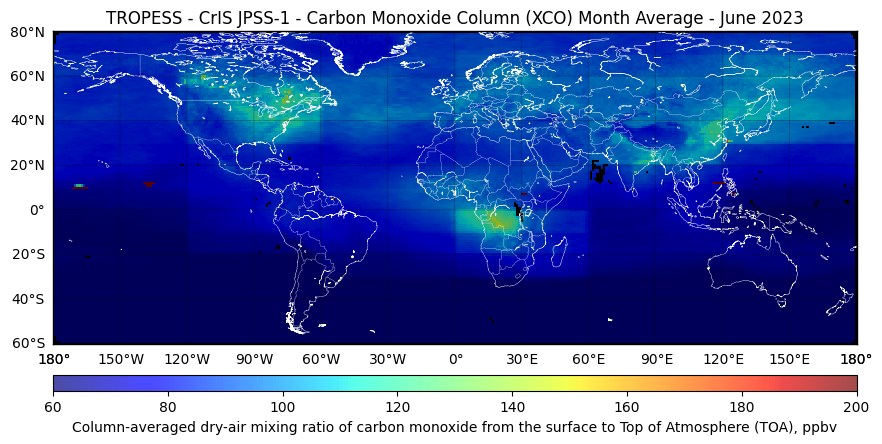

In [11]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2023, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0, shading='auto')
    
    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    title_min = np.nanmin(x_col_month_mean_2023)
    title_max = np.nanmax(x_col_month_mean_2023)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) Month Average - June 2023')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_June_2023_month_average.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


# Search CMR to extract the next month of data from June 2022

Using the collection's shortname or concept ID, we can obtain individual granules by querying https://cmr.earthdata.nasa.gov/search/granules. By querying a JSON response of the granules that we want, we can obtain each granule's S3 URL.

Here, we will parse out an S3 URL for the "TROPESS CrIS-JPSS1 L2 Carbon Monoxide for Forward Stream, Summary Product V1" dataset.

   **Shortname**: TRPSYL2COCRS1FS  
   **Concept ID**: C2247040116-GES_DISC

Our desried date range is June 1, 2022 00:00:00 to June 30, 2022 23:59:59.

In [12]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

short_name = 'TRPSYL2COCRS1FS'
concept_id = 'C2247040116-GES_DISC'

start_time = '2022-06-01T00:00:00Z'
end_time = '2022-06-30T23:59:59Z'

# OPTION 1: Using shortname
response = cmr_request({
                        'short_name': short_name,
                        'temporal': start_time+','+end_time,
                        'page_size': 200
                        })

# OPTION 2: Using concept ID
response = cmr_request({
                        'concept_id': concept_id,
                        'temporal': start_time+','+end_time,
                        'page_size': 200
                        })

granules = response.json()['feed']['entry']

# Identify the S3 URL from each granule response and save to a list

Now you can create an empty list and fill it with the S3 URL contained in each granule's response.

In [13]:
s3_urls = []
for granule in granules:
    s3_urls.append(next((item['href'] for item in granule['links'] if item["href"].startswith("s3://")), None))

Let's read June 2022 daily data products and make a time series and make a monthly average of XCO (column CO). 
The datasets should be already downloaded in the local directory ./data. 
Please refer to the tutorial about how to download TROPESS datasets from GES DISC.  

# View your list of S3 URLs

In [14]:
s3_urls

['s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220601_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220602_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220603_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220604_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220605_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220606_MUSES_R1p17_FS_F0p6.nc',
 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220607_MUSES_R1p17_FS_F0

# Open the File in Xarray as an S3 File System Object

### First, check that the file itself is intact. By calling fs.info() with S3FS, we can see some of the metadata assigned to files uploaded to S3 buckets.

In [15]:
# Files are organized by s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/year/*.nc
fn = 's3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220601_MUSES_R1p17_FS_F0p6.nc'

fs.info(fn)

{'ETag': '"d7856607105db78c69e0d5de24c2b00d"',
 'LastModified': datetime.datetime(2023, 10, 13, 18, 54, 14, tzinfo=tzutc()),
 'size': 12378941,
 'name': 'gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220601_MUSES_R1p17_FS_F0p6.nc',
 'type': 'file',
 'StorageClass': 'STANDARD',
 'VersionId': None,
 'ContentType': 'binary/octet-stream'}

# Now we will pass in the data from June 2022 directly from S3.

## Let's read the June 2022 daily data products and make a time series and make a monthly average of XCO (column CO).

In [16]:
# Define the time series array for the 'x' column
x_col_time_series_2022_june = []

# Loop over all files in the file list
for nc_file in s3_urls:
    fn = nc_file
    print("reading data from =", fn)
    fs.info(fn)
    dataset = xr.open_dataset(fs.open(f"{fn}"), decode_cf=True, engine='h5netcdf')
    
    # Read the data from your variables
    latitude = dataset.variables['latitude'][:]
    longitude = dataset.variables['longitude'][:]
    x_col = dataset.variables['x_col'][:]    

    dataset.close()

    # Filter the data for latitude 60S to 80N
    latitude_max = 80.0
    latitude_min = -60.0
    longitude_max = 180.0
    longitude_min = -180.0

    selection_only = np.where(
        (latitude > latitude_min) & (latitude < latitude_max) & 
        (longitude > longitude_min) &(longitude < longitude_max)
    )[0]

    latitude = latitude[selection_only]
    longitude = longitude[selection_only]
    x_col = x_col[selection_only]

    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    # Interpolate the data using griddata
    grid_x_col = griddata((latitude, longitude), x_col, (grid_lat, grid_lon), method='linear', rescale=True)

    # Find the distance to the nearest original point for each point in the interpolated grid
    tree = cKDTree(np.vstack((latitude, longitude)).T)
    dist, _ = tree.query(np.vstack((grid_lat.ravel(), grid_lon.ravel())).T)

    # Reshape the distance array to have the same shape as the x_col grid
    dist_grid = dist.reshape(grid_x_col.shape)

    # Mask the interpolated values that are too far from any original point
    max_distance_degrees = 3.0
    grid_x_col[dist_grid > max_distance_degrees] = np.nan
    
    # Make the time series of daily x_col for one month by appending each day's dataset. 
    x_col_time_series_2022_june.append(grid_x_col)

x_col_time_series_2022_june = np.array(x_col_time_series_2022_june)    
print(x_col_time_series_2022_june.shape)
x_col_month_mean_2022 = np.mean(x_col_time_series_2022_june, axis=0)

reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220601_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220602_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220603_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220604_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220605_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus-prod-protected/TROPESS_Summary/TRPSYL2COCRS1FS.1/2022/TROPESS_CrIS-JPSS1_L2_Summary_CO_20220606_MUSES_R1p17_FS_F0p6.nc
reading data from = s3://gesdisc-cumulus

### Let's make a global map of the June 2022 averaged XCO using Basemap. 

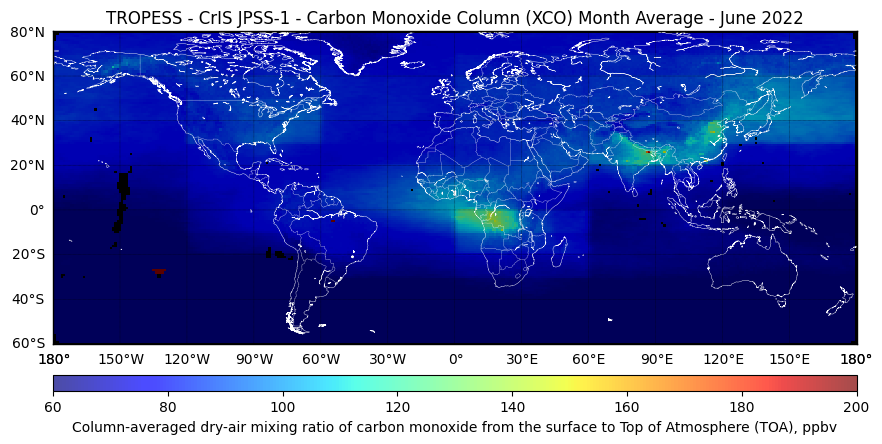

In [17]:
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the interpolated values
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the interpolated data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_month_mean_2022, latlon=True, cmap='jet', alpha=0.7, vmin=60.0, vmax=200.0, shading='auto')

    
    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    title_min = np.nanmin(x_col_month_mean_2022)
    title_max = np.nanmax(x_col_month_mean_2022)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) Month Average - June 2022')
    #\nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_June_2022_month_average.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


### Let's get the difference between June 2023 XCO and June 2022 XCO and plot the difference in a global map. 

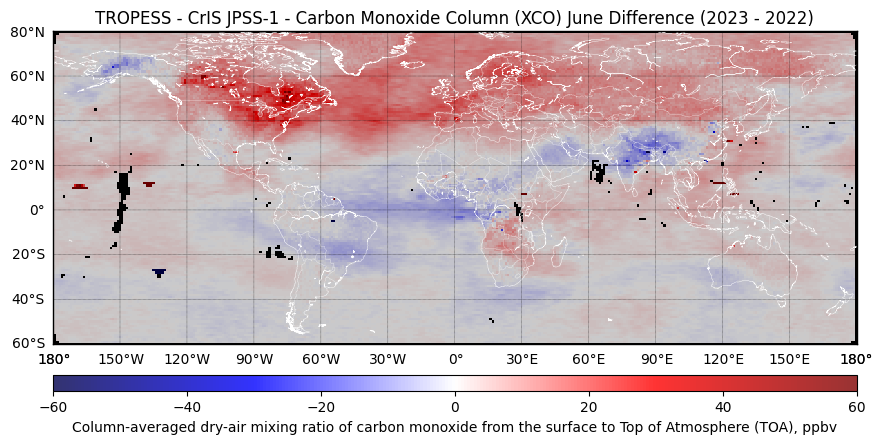

In [18]:
    x_col_diff_month_average = x_col_month_mean_2023 - x_col_month_mean_2022
    #print (x_col_diff_month_average.shape)
 
    # Calculate width and height
    aspect_ratio = (longitude_max - longitude_min) / (latitude_max - latitude_min)
    w = 3600; h = w / aspect_ratio

    # Specify figure size (in inches)
    dpi = 300; 
    plt.figure(figsize=(w / dpi, h / dpi))  

    # Create a basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-60, urcrnrlat=80,  # set latitude limits to -80 and 80
                llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and -180

    m.drawmapboundary(fill_color='black')
    m.drawcoastlines(linewidth=0.3, color='white')
    m.drawcountries(linewidth=0.2, color='white')
    #m.drawstates(linewidth=0.2, color='white')


    # Draw parallels (latitude lines) and meridians (longitude lines)
    parallels = np.arange(-60., 81., 20.)
    m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

    meridians = np.arange(-180., 181., 30.)
    m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)
    
    pixel_size_deg = 1.0 # 1 degree resolution

    # Get the grid for the map
    grid_lat, grid_lon = np.mgrid[-60:81:pixel_size_deg, -180:181:pixel_size_deg]

    
    # Plot the difference data using pcolormesh instead of scatter
    sc = m.pcolormesh(grid_lon, grid_lat, x_col_diff_month_average, latlon=True, cmap='seismic', alpha=0.8, vmin=-60, vmax=60.0, shading='auto')

    # Add a colorbar
    cbar = m.colorbar(sc, location='bottom', pad="10%")
    cbar.set_label('Column-averaged dry-air mixing ratio of carbon monoxide from the surface to Top of Atmosphere (TOA), ppbv')

    # set plot title
    title_min = np.nanmin(x_col_diff_month_average)
    title_max = np.nanmax(x_col_diff_month_average)
    plt.title(f'TROPESS - CrIS JPSS-1 - Carbon Monoxide Column (XCO) June Difference (2023 - 2022)')
    #' \nMin: {title_min:.01f}, Max: {title_max:.01f} ppbv')

    # Save figure to PNG file
    plt.savefig(f'./images_average/TROPESS_Canadian-Fires_CrIS-JPSS-1_XCO_2023_2022_June_month_diff.png', dpi=dpi, bbox_inches='tight')

    plt.show()
    plt.close()


### Let's calculate the average difference of xco in the Northeast part of North America (latitude = [40,60] and longitude [-90,-60]].)

In [19]:
    latitude_min=40
    latitude_max=60
    longitude_min=-90
    longitude_max=-60
    
    small_selection = np.where(
        (grid_lat > latitude_min) & (grid_lat < latitude_max) & 
        (grid_lon > longitude_min) &(grid_lon < longitude_max)
    )

    #print (small_selection)
    grid_lat_small = grid_lat[small_selection]
    grid_lon_small = grid_lon[small_selection]
    x_col_diff_small = x_col_diff_month_average[small_selection]
    
    
    x_col_diff_mean = x_col_diff_small.mean()
    print("Northeast America XCO increase from 2022 June to 2023 June = ", "{0:.2f}".format(x_col_diff_mean), 'ppbv')
    

Northeast America XCO increase from 2022 June to 2023 June =  20.44 ppbv


### Let's write the monthly average data and difference data in a NetCDF file for future use. 

In [20]:
import numpy as np
import datetime
from netCDF4 import Dataset,num2date,date2num


longitude_1D = np.arange(-180,181,1.0)
latitude_1D = np.arange(-60,81,1.0)

#print('length of latitude =', len(latitude_1D))
#print('length of longitude =', len(longitude_1D))

ncout = Dataset('TROPESS_CRIS_JPSS1_2022_2023_June_XCO.nc', mode='w', format='NETCDF4_CLASSIC')

ncout.createDimension('latitude', len(latitude_1D))
ncout.createDimension('longitude', len(longitude_1D))

lonvar = ncout.createVariable('longitude','float32',('longitude'))
lonvar[:] = longitude_1D

latvar = ncout.createVariable('latitude','float32',('latitude'))
latvar[:] = latitude_1D

myvar = ncout.createVariable('xco_2022_June','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_month_mean_2022;

myvar = ncout.createVariable('xco_2023_June','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_month_mean_2023;

myvar = ncout.createVariable('xco_diff','float32',('latitude','longitude'))
myvar.setncattr('units','ppbv')
myvar[:] = x_col_diff_month_average;
ncout.close();


